In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

In [66]:
df = pd.read_csv("Dataset/insurance.csv")

In [67]:
# Display data
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [68]:
# Analyze potential missing values / NaN (Result: We do not have any missing values)
df[df.isnull().any(axis=1)]

,age,sex,bmi,children,smoker,region,charges


In [69]:
# Label encoded: Converted categorical labels into integer codes
cols = ["sex", "smoker", "region"]
for col in cols:
    df[col] = df[col].astype("category").cat.codes

In [70]:
corr = df.select_dtypes(include=['number']).corr()["charges"]
corr

age         0.299008
sex         0.057292
bmi         0.198341
children    0.067998
smoker      0.787251
region     -0.006208
charges     1.000000
Name: charges, dtype: float64

Lets take a look at the bar plot for a better visual understanding.

Text(0, 0.5, 'Correlation level')

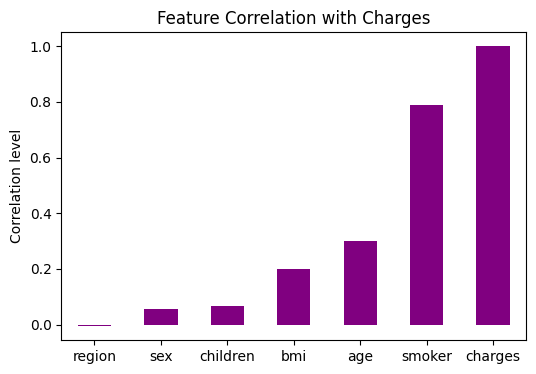

In [71]:
ax = corr.sort_values().plot.bar(figsize=(6,4), color="purple")

ax.tick_params(axis="x", labelrotation=0)
ax.set_title("Feature Correlation with Charges")
ax.set_ylabel("Correlation level")

Text(0.5, 1.0, 'Distribution of Non-Smokers')

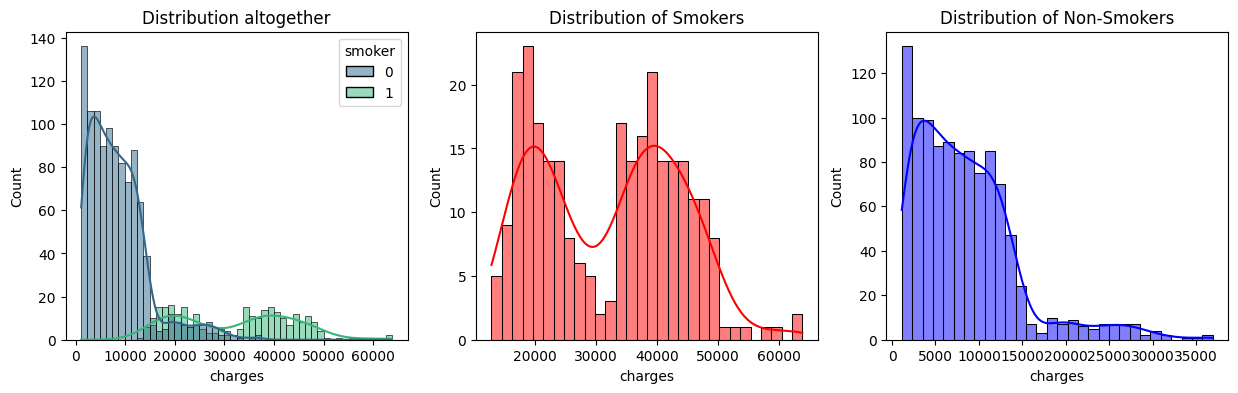

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(data=df, x="charges", hue="smoker", kde=True, bins=50, palette="viridis", ax=axes[0])
axes[0].set_title("Distribution altogether")

sns.histplot(data=df[df["smoker"] == 1], x="charges", bins=30, color="red", kde=True, ax=axes[1])
axes[1].set_title("Distribution of Smokers")
sns.histplot(data=df[df["smoker"] == 0], x="charges", bins=30, color="blue", kde=True, ax=axes[2])
axes[2].set_title("Distribution of Non-Smokers")

Text(0.5, 1.0, 'Smoker vs Non-Smoker')

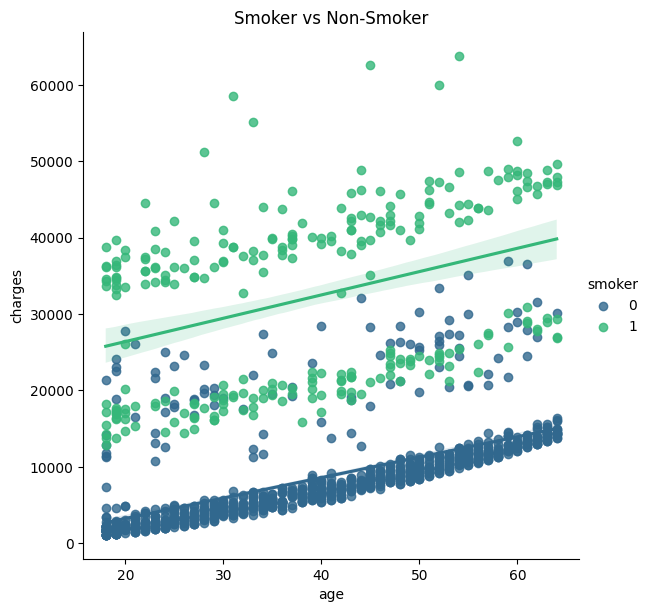

In [73]:
sns.lmplot(x="age", y="charges", hue="smoker", palette="viridis", height=6,data=df)
plt.title("Smoker vs Non-Smoker")

In [74]:
# Check mean
df.groupby("smoker")["charges"].mean()

smoker
0     8434.268298
1    32050.231832
Name: charges, dtype: float64

There is a high correlation between smoking status and charges, demonstrating that smokers tend to spend more on treatments.

# Linear Regression to predict Insurance Cost

In [121]:
# Prepare Data and implement one hot encode categoricals
#df["region"] = df["region"].astype("category")
X = pd.get_dummies(df.drop(columns="charges"))
y = df["charges"]    
X

,age,sex,bmi,children,smoker,region_0,region_1,region_2,region_3
0,19,0,27.900,0,1,False,False,False,True
1,18,1,33.770,1,0,False,False,True,False
2,28,1,33.000,3,0,False,False,True,False
3,33,1,22.705,0,0,False,True,False,False
4,32,1,28.880,0,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,False,True,False,False
1334,18,0,31.920,0,0,True,False,False,False
1335,18,0,36.850,0,0,False,False,True,False
1336,21,0,25.800,0,0,False,False,False,True


In [122]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [123]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=432)

In [124]:
# Train model by using training data to learn best intercept and slope
model = LinearRegression().fit(x_train, y_train)

# Bayesian Information Criterion (BIC)

BIC is a score used to select the best model by balancing how well the model fits the data (low error is better) and how simple the model is (fewer parameters is better)

---

## BIC Formula

$$
\text{BIC}
\;=\;
n \,\ln\!\left(\frac{\mathrm{RSS}}{n}\right)
\;+\;
k \,\ln n
$$

where  
- \(n\) is the number of observations,  
- $\mathrm{RSS} \;=\; \sum_{i=1}^{n}\bigl(y_i - \hat y_i\bigr)^{2}$ is the residual sum of squares,  that measures the distance between each observed point and its model predicted values.
- \(k\) is the number of estimated parameters (slopes + intercept).

---

## Simple Linear Regression Model

Using the training data, we predict \(y\) from a single feature \(x\) via:

$$
\hat y_i
= \beta_0 + \beta_1\,x_i
$$

where the coefficients:
- $\beta_1\,x_i$ is the slope.
- $\beta_0$ is the intercept.

In [125]:
# BIC calculation 
y_pred_train = model.predict(x_train) # Compute residual on training data for r^2
y_pred_test = model.predict(x_test) # Compute residual on testing data for r^2

In [126]:
# Now we plug in the values for the BIC formula
n, p = x_train.shape
rss = np.sum((y_train - y_pred_train)**2)
# Slopes + intercept
k = p + 1
bic = n * np.log(rss / n) + k * np.log(n)

In [127]:
# Root-Mean-Squared Error
error = root_mean_squared_error(y_test, y_pred_test)

In [128]:
print(f"BIC: {bic:,.0f}")
# Compare results
print(f"Test r^2: {r2_score(y_test, y_pred_test):.3f}")
print(f"RMSE: {error:,.0f}")
print(f"Training r^2: {r2_score(y_train, y_pred_train):.3f}")

BIC: 18,703
Test r^2: 0.758
RMSE: 6,054
Training r^2: 0.748


With our testing and training r^2 values, it seems like our models are not overfitting. And are able to capure most of the differences in the data. 

Our RMSE is within about $6k of the true cost of charges.

In [129]:
for degree in range(1, 6):
    # Use polynomial features and fit
    x_pol = PolynomialFeatures(degree, include_bias=False).fit_transform(X)
    # Split
    x_tr, x_te, y_tr, y_te = train_test_split(x_pol, y, test_size=0.2, random_state=432)

    # fit model
    model = LinearRegression().fit(x_tr, y_tr)

    # Compute BIC
    rss = np.sum((y_tr - model.predict(x_tr))**2)
    n, p = x_tr.shape
    # Slopes + intercept
    k = p + 1
    bic = n * np.log(rss / n) + k * np.log(n)

    # To check R^2 values on test data
    y_pred = model.predict(x_te)
    r2_test = r2_score(y_te, y_pred)

    print(f"degree:{degree} BIC={bic:,.0f} R^2 = {r2_test:.3f}")

degree:1 BIC=18,703 R^2 = 0.758
degree:2 BIC=18,479 R^2 = 0.836
degree:3 BIC=19,540 R^2 = 0.819
degree:4 BIC=22,797 R^2 = 0.430
degree:5 BIC=31,479 R^2 = -0.534


The degree 2 model offers a strong balance between model simplicity and predictive power. It has a few extra parameters and achieves a higher test R square. 

## Fitting our Final Model (Linear Regression)

In [130]:
# Use make_pipeline that lets us chain preprocessing steps
fin_model = make_pipeline(FunctionTransformer(np.log1p, validate=True),
                          PolynomialFeatures(degree=2, include_bias=False),
                          LinearRegression()
                         )

In [131]:
# Fit final model
fin_model.fit(x_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<ufunc 'log1p'>, validate=True)),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

In [132]:
y_pred = fin_model.predict(x_test)
print(f"R^2: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.3f}")

R^2: 0.84
RMSE: 4913.454


Our root mean squared error reduced as it is closest to the actual values in the dataset. 
The r-squared value has increased which explains a larger fraction of the spread.

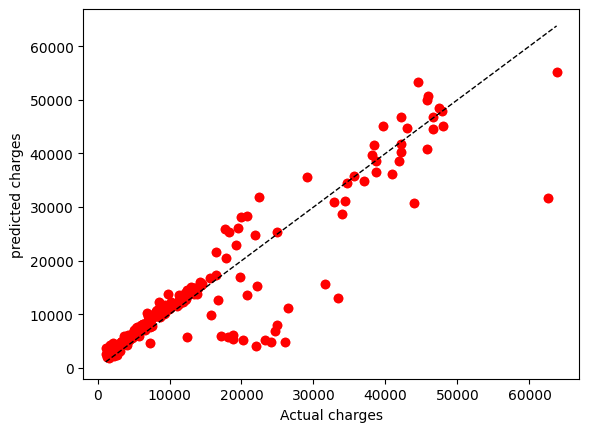

In [133]:
plt.scatter(y_test, y_pred, color='red')
plt.xlabel("Actual charges")
plt.ylabel("predicted charges")
mn = min(y_test.min(), y_pred.min())
mx = max(y_test.max(), y_pred.max())
plt.scatter(y_test, y_pred, color="red", alpha=0.6)
plt.plot([mn, mx], [mn, mx], "k--", linewidth=1)
plt.show()

Text(0, 0.5, 'Residuals')

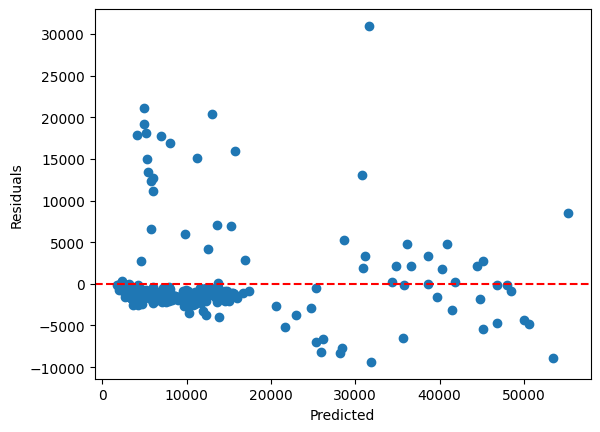

In [134]:
# Plotting the residuals to observe how well our model fits with the observed values and the predicted data points
res = y_test - y_pred
plt.scatter(y_pred, res)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")